In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as pr
import sklearn.linear_model as linear
import matplotlib.pyplot as plt
# import sklearn as sk

In [2]:
!head adult.data

39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, <=50K
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0, 16, Jamaica, <=50K
52, Self-emp-not-inc, 209642, HS-grad, 9, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 45, United-States, >50K
31, 

In [3]:
!tail -n 14 adult.names

age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Ri

In [4]:
with open('adult.names') as file:
    rows = file.read().split('\n')[-15:]
    col_names = [row.split(':')[0] for row in rows][:-1] + ['label']

In [5]:
col_names

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'label']

In [6]:
df = pd.read_csv('adult.data', header=None, names=col_names, skipinitialspace=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
test_df = pd.read_csv('adult.test', header=None, names=col_names, skipinitialspace=True)

In [8]:
all_data = pd.concat([df, test_df])


In [9]:
df[df.sex == 'Male'].fnlwgt.sum()

4178699874

In [10]:
df[df.sex != 'Male'].fnlwgt.sum()

2000673518

In [11]:
all_data[all_data.sex == 'Male'].fnlwgt.sum()

6259887256

In [12]:
all_data[all_data.sex != 'Male'].fnlwgt.sum()

3003688406

In [13]:
df.sort_values(by='fnlwgt')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
17096,25,?,12285,Some-college,10,Never-married,?,Not-in-family,Amer-Indian-Eskimo,Female,0,0,20,United-States,<=50K
27207,23,Private,13769,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Amer-Indian-Eskimo,Male,0,0,30,United-States,<=50K
25743,46,Local-gov,14878,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,Philippines,>50K
24012,26,Private,18827,Some-college,10,Never-married,Transport-moving,Not-in-family,White,Male,0,0,40,United-States,<=50K
10826,25,Private,19214,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8258,35,Private,1226583,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,52,United-States,>50K
15569,29,Private,1268339,HS-grad,9,Married-spouse-absent,Tech-support,Own-child,Black,Male,0,0,40,United-States,<=50K
16739,45,Private,1366120,Assoc-voc,11,Divorced,Other-service,Not-in-family,White,Female,0,0,8,United-States,<=50K
18138,39,Private,1455435,Assoc-acdm,12,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [14]:
y = df['label'] == '>50K'

In [15]:
y.mean()

0.2408095574460244

In [16]:
df['fnlwgt'].sum()

6179373392

In [17]:
x = df.drop(columns=['label', 'fnlwgt', 'sex', 'native-country', 'marital-status'])
x_categorical = x.select_dtypes('object')
x_numerical = x.select_dtypes('int')

In [18]:
protected_label = df['sex'] == 'Female'

In [19]:
x_categorical

,workclass,education,occupation,relationship,race
0,State-gov,Bachelors,Adm-clerical,Not-in-family,White
1,Self-emp-not-inc,Bachelors,Exec-managerial,Husband,White
2,Private,HS-grad,Handlers-cleaners,Not-in-family,White
3,Private,11th,Handlers-cleaners,Husband,Black
4,Private,Bachelors,Prof-specialty,Wife,Black
...,...,...,...,...,...
32556,Private,Assoc-acdm,Tech-support,Wife,White
32557,Private,HS-grad,Machine-op-inspct,Husband,White
32558,Private,HS-grad,Adm-clerical,Unmarried,White
32559,Private,HS-grad,Adm-clerical,Own-child,White


In [20]:
x_numerical

,age,education-num,capital-gain,capital-loss,hours-per-week
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40
3,53,7,0,0,40
4,28,13,0,0,40
...,...,...,...,...,...
32556,27,12,0,0,38
32557,40,9,0,0,40
32558,58,9,0,0,40
32559,22,9,0,0,20


In [21]:
import sklearn.preprocessing as pre

In [22]:
enc = pre.OneHotEncoder(sparse=False)

In [23]:
x_one_hot = enc.fit_transform(x_categorical)

In [24]:
# enc.fit_transform(df.select_dtypes('object')).shape

In [25]:
enc.categories_

[array(['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private',
        'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'],
       dtype=object),
 array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
        'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
        'Masters', 'Preschool', 'Prof-school', 'Some-college'],
       dtype=object),
 array(['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair',
        'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners',
        'Machine-op-inspct', 'Other-service', 'Priv-house-serv',
        'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support',
        'Transport-moving'], dtype=object),
 array(['Husband', 'Not-in-family', 'Other-relative', 'Own-child',
        'Unmarried', 'Wife'], dtype=object),
 array(['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other',
        'White'], dtype=object)]

In [26]:
cols = []
for main_category, sub_categories in zip(x_categorical.columns, enc.categories_):
    cols += [f'{main_category}_{sub}' for sub in sub_categories]

In [27]:
cols

['workclass_?',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'education_10th',
 'education_11th',
 'education_12th',
 'education_1st-4th',
 'education_5th-6th',
 'education_7th-8th',
 'education_9th',
 'education_Assoc-acdm',
 'education_Assoc-voc',
 'education_Bachelors',
 'education_Doctorate',
 'education_HS-grad',
 'education_Masters',
 'education_Preschool',
 'education_Prof-school',
 'education_Some-college',
 'occupation_?',
 'occupation_Adm-clerical',
 'occupation_Armed-Forces',
 'occupation_Craft-repair',
 'occupation_Exec-managerial',
 'occupation_Farming-fishing',
 'occupation_Handlers-cleaners',
 'occupation_Machine-op-inspct',
 'occupation_Other-service',
 'occupation_Priv-house-serv',
 'occupation_Prof-specialty',
 'occupation_Protective-serv',
 'occupation_Sales',
 'occupation_Tech-support',
 'occupation_Transp

In [28]:
x_enc = pd.DataFrame(data=x_one_hot, columns=cols)
x_post = pd.concat([x_numerical, x_enc], axis=1)

In [29]:
x_post

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,13,2174,0,40,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,50,13,0,0,13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,38,9,0,0,40,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,53,7,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28,13,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,0,0,38,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
32557,40,9,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32558,58,9,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
32559,22,9,0,0,20,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
import sklearn.linear_model as linear

In [31]:
model = linear.LogisticRegression(penalty='none', max_iter=2000)
model.fit(x_post, y)

LogisticRegression(max_iter=2000, penalty='none')

In [32]:
probs = model.predict_proba(x_post)

In [33]:
model.score(x_post, y)

0.8515094745247381

In [34]:
((probs[:, 1] >= 0.5) == y).mean()

0.8515094745247381

In [35]:
model.score(x_post[protected_label], y[protected_label])

0.9267477485841612

In [36]:
model.score(x_post[~protected_label], y[~protected_label])

0.8143184947223497

In [37]:
import sklearn.metrics as metrics

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(y, probs[:, 1])

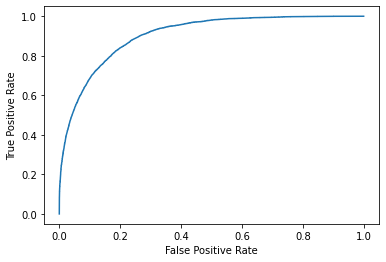

In [39]:
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

/var/folders/nc/dhtws2m1317bwzbsxq9n3_gc0000gn/T/ipykernel_45912/2117704448.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


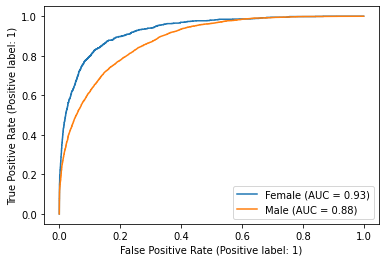

In [40]:
fig, ax = plt.subplots()

metrics.RocCurveDisplay.from_predictions(y[protected_label], probs[protected_label, 1], ax=ax, name='Female')
metrics.RocCurveDisplay.from_predictions(y[~protected_label], probs[~protected_label, 1], ax=ax, name='Male')
fig.show()

In [41]:
fpr, tpr, thresholds = metrics.roc_curve(y, probs[:, 1])


In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y, probs[:, 1])

In [43]:
def rate_to_th(rate: float, probs: np.ndarray):
    return np.sort(probs)[max(int((1 - rate) * probs.shape[0]) - 1, 0)]

In [44]:
male_probs = probs[~protected_label, 1]
female_probs = probs[protected_label, 1]
y_m = y[~protected_label]
y_f = y[protected_label]

rates = np.linspace(0, 1, 100)

th_m = list(map(lambda r: rate_to_th(r, male_probs), rates))
th_f = list(map(lambda r: rate_to_th(r, female_probs), rates))

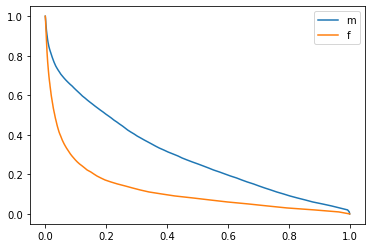

In [45]:
fig, ax = plt.subplots()

ax.plot(th_m, rates, label='m')
ax.plot(th_f, rates, label='f')
ax.legend()

In [46]:
def th_to_profit(th: float, probs: np.ndarray, y: np.ndarray):
    yhat = (probs > th) * 1
    return (yhat == y)

In [47]:
p = [
    pd.concat([
        th_to_profit(thm, male_probs, y_m),
        th_to_profit(thf, female_probs, y_f)]
    ).mean()
    for (thm, thf) in zip(th_m, th_f)]

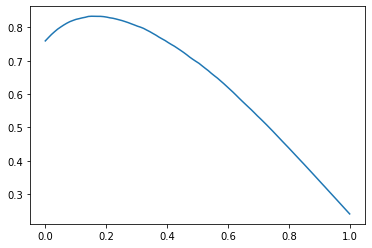

In [48]:
plt.plot(rates, p)

In [49]:
np.array(p).argmax()

15

In [50]:
th_f[15]

0.23720545100145635

In [51]:
th_m[15]

0.6842246335895886

In [52]:
max(p)

0.833082522035564

In [53]:
(male_probs >= th_m[15]).mean()

0.1515832950894906

In [54]:
(female_probs >= th_f[15]).mean()

0.15161080679602637

In [55]:
y.mean()

0.2408095574460244

In [56]:
(probs[:, 1] >= 0.5).mean()

0.19538711956021007

In [66]:
ths = np.linspace(0, 1, 10001)

In [67]:


pm = [th_to_profit(t, male_probs, y_m).mean() for t in ths]
pf = [th_to_profit(t, female_probs, y_f).mean() for t in ths]

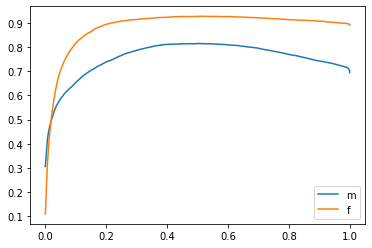

In [68]:
fig, ax = plt.subplots()

ax.plot(ths, pm, label='m')
ax.plot(ths, pf, label='f')
ax.legend()

In [69]:
np.array(pm).argmax()

5029

In [70]:
np.array(pf).argmax()

5175

In [71]:
ths[5029]

0.5029

In [72]:
ths[5175]

0.5175000000000001

In [73]:
pd.concat([
        th_to_profit(ths[5029], male_probs, y_m),
        th_to_profit(ths[5175], female_probs, y_f)]
    ).mean()

0.8519394367494856